In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (update the path as needed)
file_path = "/content/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean column names to remove leading/trailing spaces
df.columns = df.columns.str.strip()

# Check if 'Humanitarian_Class' exists
if "Humanitarian_Class" not in df.columns:
    raise KeyError("Column 'Humanitarian_Class' not found in the dataset. Please check the column names.")

# Perform stratified splitting based on 'Humanitarian_Class' (5 classes)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Humanitarian_Class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Humanitarian_Class"], random_state=42)

# Save the split datasets
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Humanitarian_Class"].value_counts(),
    "Validation (15%)": val_df["Humanitarian_Class"].value_counts(),
    "Test (15%)": test_df["Humanitarian_Class"].value_counts(),
    "Total": df["Humanitarian_Class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("split_summary.csv")

print("Data split completed and saved as CSV files.")

Data split completed and saved as CSV files.



📊 Class Distribution Before SMOTE:
Train Set:
 humanitarian_class
3    4549
4    3659
1    2643
2    1042
0     764
Name: count, dtype: int64
Test Set:
 humanitarian_class
3    975
4    784
1    567
2    224
0    163
Name: count, dtype: int64
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Final Model Accuracy: 0.6550

📋 Classification Report:
                                        precision    recall  f1-score   support

                  affected_individuals       0.57      0.53      0.55       163
rescue_volunteering_or_donation_effort       0.70      0.66      0.68       567
     infrastructure_and_utility_damage       0.66      0.44      0.53       224
            other_relevant_information       0.65      0.70      0.67       975
                      not_humanitarian       0.65      0.68      0.66       784

                              accuracy                           0.65      2713
                             macro avg       0.64      0.60      0.62      

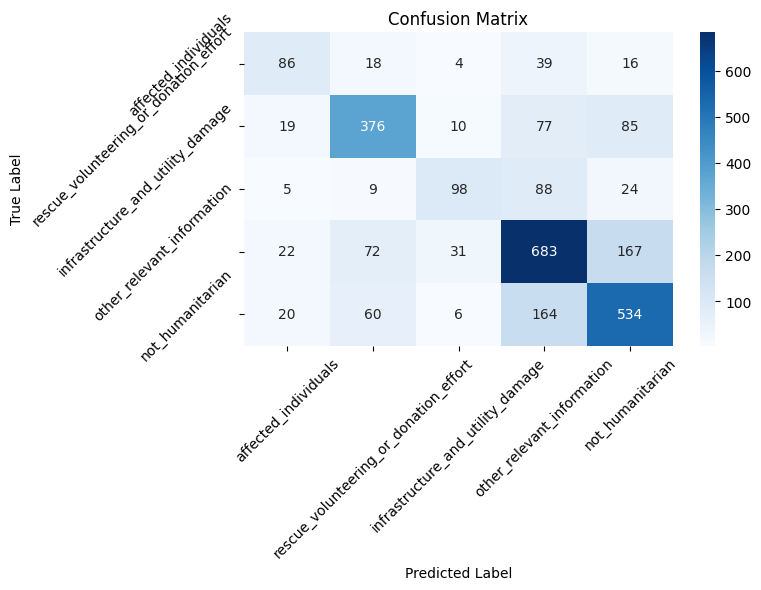

In [ ]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from collections import Counter
import spacy

# Load spaCy model (medium or large preferred)
nlp = spacy.load("en_core_web_md")  # use 'en_core_web_sm' only if others are not available

# Paths to data
train_path = "/content/train_data.csv"
val_path = "/content/val_data.csv"
test_path = "/content/test_data.csv"

# Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# Normalize column names
for df in [train_df, val_df, test_df]:
    df.columns = df.columns.str.strip().str.lower()

# Label mapping
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

# Clean labels
for df in [train_df, val_df, test_df]:
    df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

# Convert labels
y_train = train_df['humanitarian_class'].map(label_map).astype(int)
y_test = test_df['humanitarian_class'].map(label_map).astype(int)

# Fill missing processed_data
for df in [train_df, val_df, test_df]:
    df['processed_data'] = df['processed_data'].fillna("")

# --- ELAMO Embedding Feature Extraction ---
def extract_elamo_features(texts):
    lexical_vectors = []
    pos_counts = []
    lemma_counts = []

    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        # Average word vector
        if doc.has_vector:
            lexical_vectors.append(doc.vector)
        else:
            lexical_vectors.append(np.zeros(nlp.vocab.vectors_length))

        # Morphological features
        pos_tags = [token.pos_ for token in doc]
        lemmas = [token.lemma_ for token in doc]
        pos_counts.append([len(set(pos_tags))])
        lemma_counts.append([len(set(lemmas))])

    return np.hstack((lexical_vectors, pos_counts, lemma_counts))

# Extract features
X_train_combined = extract_elamo_features(train_df['processed_data'])
X_test_combined = extract_elamo_features(test_df['processed_data'])

# --- Show Class Distribution Before SMOTE ---
print("\n📊 Class Distribution Before SMOTE:")
print("Train Set:\n", y_train.value_counts().rename(label_map))
print("Test Set:\n", y_test.value_counts().rename(label_map))


# --- Apply SMOTE ---
max_class_samples = max(Counter(y_train).values())
sampling_strategy = {label: max_class_samples for label in np.unique(y_train)}

smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

# --- Hyperparameter Tuning ---
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
random_search.fit(X_train_resampled, y_train_resampled)

# Train best model
best_rf = random_search.best_estimator_
best_rf.fit(X_train_resampled, y_train_resampled)

# Save model
joblib.dump(best_rf, "random_forest_elamo_multi.pkl")

# Predict
y_pred = best_rf.predict(X_test_combined)

# --- Evaluation ---
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Final Model Accuracy: {accuracy:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# NOTE: ROC AUC is not straightforward for multi-class using random forest,
# you could use One-vs-Rest strategy with roc_auc_score (optional).

